# Modeling and Simulation in Python

Chapter 16

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

## Code from previous notebooks

In [2]:
def update_func(state, t, system):
    """Update the thermal transfer model.
    
    state: State (temp)
    t: time
    system: System object
    
    returns: State (temp)
    """
    unpack(system)
    
    T = state.T
    T += -r * (T - T_env) * dt
    
    return State(T=T)

In [3]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.
    
    Add a TimeFrame to the System: results
    
    system: System object
    update_func: function that updates state
    """
    unpack(system)
    
    frame = TimeFrame(columns=init.index)
    frame.row[0] = init
    ts = linrange(0, t_end, dt)
    
    for t in ts:
        frame.row[t+dt] = update_func(frame.row[t], t, system)
        
    # store the final temperature in T_final
    system.T_final = get_last_value(frame.T)
    
    return frame

In [4]:
def make_system(T_init, r, volume, t_end):
    """Makes a System object with the given parameters.

    T_init: initial temperature in degC
    r: heat transfer rate, in 1/min
    volume: volume of liquid in mL
    t_end: end time of simulation
    
    returns: System object
    """
    init = State(T=T_init)
    
    # T_final is used to store the final temperature.
    # Before the simulation runs, T_final = T_init
    T_final = T_init

    T_env = 22 
    dt = 1
                
    return System(locals())

### Using `fsolve`

As a simple example, let's find the roots of this function; that is, the values of `x` that make the result 0.

In [5]:
def func(x):
    return (x-1) * (x-2) * (x-3)

`modsim.py` provides `fsolve`, which does some error-checking and then runs `scipy.optimize.fsolve`.  The first argument is the function whose roots we want.  The second argument is an initial guess.

In [6]:
fsolve(func, x0=0)

array([1.])

Usually the root we get is the one that's closest to the initial guess.

In [7]:
fsolve(func, 1.9)

array([2.])

In [8]:
fsolve(func, 2.9)

array([3.])

But not always.

In [9]:
fsolve(func, 1.5)

array([3.])

We want to find the value of `r` that makes the final temperature 70, so we define an "error function" that takes `r` as a parameter and returns the difference between the final temperature and the goal.

In [10]:
def error_func1(r):
    """Runs a simulation and returns the `error`.
    
    r: heat transfer rate, in 1/min
    
    returns: difference between final temp and 70 C
    """
    system = make_system(T_init=90, r=r, volume=300, t_end=30)
    results = run_simulation(system, update_func)
    print(r)
    return system.T_final - 70

With `r=0.01`, we end up a little too warm.

In [11]:
error_func1(r=0.01)

0.01


2.2996253904030937

The return value from `fsolve` is an array with a single element, the estimated value of `r`.

In [12]:
solution = fsolve(error_func1, 0.01)
r_coffee = solution[0]
r_coffee

0.01
[0.01]
[0.01]
[0.01]
[0.01]
[0.01150871]
[0.01154231]
[0.01154308]
[0.01154308]


0.011543084583973956

If we run the simulation with the estimated value of `r`, the final temperature is 70 C, as expected.

In [13]:
coffee = make_system(T_init=90, r=r_coffee, volume=300, t_end=30)
results = run_simulation(coffee, update_func)
coffee.T_final

70.0000000000064

**Exercise:**  When you call `fsolve`, it calls `error_func1` several times.  To see how this works, add a print statement to `error_func1` and run `fsolve` again.

Look above

**Exercise:** Repeat this process to estimate `r_milk`, given that it starts at 5 C and reaches 20 C after 15 minutes.  

Before you use `fsolve`, you might want to try a few values for `r_milk` and see how close you can get by trial and error.  Here's an initial guess to get you started:

In [14]:
r_milk = 0.2
milk = make_system(T_init=5, t_end=15, r=r_milk, volume=50)
results = run_simulation(milk, update_func)
milk.T_final

21.40186567448986

In [15]:
def error_func2(r):
    """Runs a simulation and returns the `error`.
    
    r: heat transfer rate of milk, in 1/min
    
    returns: difference between final temp and 20 C
    """
    system = make_system(T_init=5, r=r, volume=50, t_end=15)
    results = run_simulation(system, update_func)
    return system.T_final - 20

In [16]:
solution = fsolve(error_func2, .2)
r_milk = solution[0];
r_milk

0.1329607893546664

In [17]:
# Solution goes here

In [18]:
# Solution goes here

### Mixing liquids

The following function takes `System` objects that represent two liquids, computes the temperature of the mixture, and returns a new `System` object that represents the mixture.

In [19]:
def mix(s1, s2):
    """Simulates the mixture of two liquids.
    
    s1: System representing coffee
    s2: System representing milk
    
    returns: System representing the mixture
    """
    assert s1.t_end == s2.t_end
    
    V_mix = s1.volume + s2.volume
    
    T_mix = (s1.volume * s1.T_final + 
             s2.volume * s2.T_final) / V_mix
    
    mixture = make_system(T_init=T_mix,
                          t_end=0,
                          r=s1.r,
                          volume=V_mix)
    
    return mixture

## Mixing at the end

First we'll see what happens if we add the milk at the end.  We'll simulate the coffee and the milk separately.

In [20]:
coffee = make_system(T_init=90, t_end=30, r=r_coffee, volume=300)
coffee_results = run_simulation(coffee, update_func)
coffee.T_final

70.0000000000064

In [21]:
milk = make_system(T_init=5, t_end=30, r=r_milk, volume=50)
milk_results = run_simulation(milk, update_func)
milk.T_final

21.764705882352956

Here's what the results look like.

Saving figure to file figs/chap07-fig01.pdf


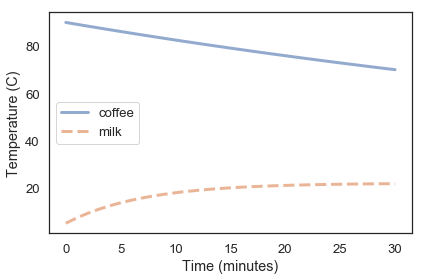

In [22]:
plot(coffee_results.T, label='coffee')
plot(milk_results.T, '--', label='milk')

decorate(xlabel='Time (minutes)',
         ylabel='Temperature (C)',
         loc='center left')

savefig('figs/chap07-fig01.pdf')

Here's what happens when we mix them.

In [23]:
mix_last = mix(coffee, milk)
mix_last.T_final

63.109243697484466

## Mixing immediately

Next here's what we get if we add the milk immediately.

In [24]:
coffee = make_system(T_init=90, t_end=0, r=r_coffee, volume=300)
milk = make_system(T_init=5, t_end=0, r=r_milk, volume=50)

,values
dt,1
T_env,22
T_final,5
init,T 5 dtype: int64
t_end,0
volume,50
r,0.132961
T_init,5


In [25]:
mix_first = mix(coffee, milk)
mix_first.t_end = 30
results = run_simulation(mix_first, update_func)
mix_first.T_final

61.42857142857666

The following function takes `t_add`, which is the time when the milk is added, and returns the final temperature.

In [26]:
def run_and_mix(t_add, t_total):
    """Simulates two liquids and them mixes them at t_add.
    
    t_add: time in minutes
    t_total: total time to simulate, min
    
    returns: final temperature
    """
    coffee = make_system(T_init=90, t_end=t_add, 
                         r=r_coffee, volume=300)
    coffee_results = run_simulation(coffee, update_func)

    milk = make_system(T_init=5, t_end=t_add, 
                       r=r_milk, volume=50)
    milk_results = run_simulation(milk, update_func)
    
    mixture = mix(coffee, milk)
    mixture.t_end = t_total - t_add
    results = run_simulation(mixture, update_func)

    return mixture.T_final

We can try it out with a few values.

In [27]:
run_and_mix(t_add=0, t_total=30)

61.42857142857666

In [28]:
run_and_mix(t_add=15, t_total=30)

62.90280912845781

In [29]:
run_and_mix(t_add=30, t_total=30)

63.109243697484466

And then sweep a range of values for `t_add`

In [30]:
sweep = SweepSeries()
for t_add in linspace(0, 30, 11):
    sweep[t_add] = run_and_mix(t_add, 30)

Here's what the result looks like.

Saving figure to file figs/chap07-fig02.pdf


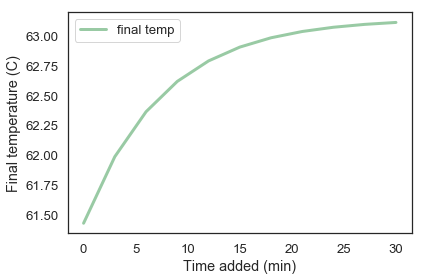

In [31]:
plot(sweep, label='final temp', color='C2')
decorate(xlabel='Time added (min)',
         ylabel='Final temperature (C)')

savefig('figs/chap07-fig02.pdf')

### Analysis

Now we can use the analytic result to compute temperature as a function of time.  The following function is similar to `run_simulation`.

In [32]:
def run_analysis(system):
    """Computes temperature using the analytic solution.
        
    system: System object
    
    returns: TimeFrame
    """
    unpack(system)
    
    T_init = init.T    
    ts = linrange(0, t_end, dt)
    
    T_array = T_env + (T_init - T_env) * exp(-r * ts)
    
    # to be consistent with run_simulation, we have to
    # put the array into a TimeFrame
    results = TimeFrame(T_array, index=ts, columns=['T'])
    system.T_final = get_last_value(results.T)

    return results

Here's how we run it.  From the analysis (see `chap14analysis.ipynb`), we have the computed value of `r_coffee2`

In [33]:
r_coffee2 = 0.011610223142273859
coffee2 = make_system(T_init=90, r=r_coffee2, volume=300, t_end=30)
results = run_analysis(coffee2)
coffee2.T_final

70.56053840222036

And we can compare to the results from simulation.

In [34]:
coffee = make_system(T_init=90, r=r_coffee, volume=300, t_end=30)
results = run_simulation(coffee, update_func)
coffee.T_final

70.0000000000064

They are identical except for a small roundoff error.

In [35]:
coffee.T_final - coffee2.T_final

-0.5605384022139646

## Exercises

**Exercise:**  Suppose the coffee shop won't let me take milk in a separate container, but I keep a bottle of milk in the refrigerator at my office.  In that case is it better to add the milk at the coffee shop, or wait until I get to the office?

Hint: Think about the simplest way to represent the behavior of a refrigerator in this model.  The change you make to test this variation of the problem should be very small!

In [41]:
coffee = make_system(T_init=90, t_end=30, r=r_coffee, volume=300)
results = run_simulation(coffee, update_func)
print (coffee.T_final )
print(get_last_value(results.T))
milk = make_system(T_init=5, t_end=0, r=r_milk, volume=50)
milk.T_Final = milk.T_init
milk.t_end = 30
mixture = mix(coffee, milk)
mixture.T_init

70.0000000000064
70.0000000000064


60.714285714291194

In [42]:
print("The temperature after mixing immediately is ")
print(mix_first.T_final)
print("and the temperature after mixing at the office is ")
print(mixture.T_init)

The temperature after mixing immediately is 
61.42857142857666
and the temperature after mixing at the office is 
60.714285714291194
